# 3.2 DEVELOPING A SEARCH ENGINE

### Installing the Dataset
Uncomment the cell below for your first run if you're using a local machine.

In [ ]:
# !wget https://dblp.uni-trier.de/xml/dblp.xml.gz
# !wget https://dblp.uni-trier.de/xml/dblp.dtd
# !gzip -d dblp.xml.gz

### Installing Dependencies
Uncomment the cell below for your first run if you're using a local machine.

In [ ]:
# !pip3 install nltk -q
# !pip3 install lxml -q
# !pip3 install whoosh -q
# !pip3 install matplotlib -q

### Importing Dependencies

In [ ]:
import os
import json
from lxml import etree

import time
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np

from whoosh.index import create_in, open_dir
from whoosh.fields import Schema, TEXT, ID, STORED
from whoosh.analysis import StandardAnalyzer
from whoosh.qparser import QueryParser, MultifieldParser

# Download the NLTK stopwords (uncomment the code below if running for the first time)
# nltk.download('stopwords')

### Parsing the `dblp.xml` file

In [ ]:
def parse_dblp(path, batch_size=60000):
    context = etree.iterparse(path, load_dtd=True, events=('end',), tag=('article', 'inproceedings', 'proceedings'))
    papers = []
    batch_index = 0

    # Creating a directory for the JSON files
    os.makedirs('dataset', exist_ok=True)

    for event, elem in context:
        title = elem.find('title').text
        authors = [author.text for author in elem.findall('author')]
        venue = elem.find('booktitle').text if elem.find('booktitle') is not None else elem.find('journal').text if elem.find('journal') is not None else None
        year = elem.find('year').text if elem.find('year') is not None else None

        papers.append({
            'title': title,
            'authors': authors,
            'venue': venue,
            'year': year
        })

        # calling clear() to free up RAM after fetching the last node
        elem.clear()

        # eliminating now-empty references from the root node to element
        while elem.getprevious() is not None:
            del elem.getparent()[0]

        # If we've reached the batch size, save these papers to a new JSON file
        if len(papers) == batch_size:
            with open(f'dataset/dblp_{batch_index}.json', 'w') as f:
                json.dump(papers, f)
            papers = []
            batch_index += 1

    # Saving any remaining papers to a new JSON file
    if papers:
        with open(f'dataset/dblp_{batch_index}.json', 'w') as f:
            json.dump(papers, f)

parse_dblp('dblp.xml')


### Indexing the data

##### Getting Total number of documents

In [ ]:
total_documents = sum([len(json.load(open(os.path.join('dataset', filename)))) for filename in os.listdir('dataset')])
documents_per_10_percent = total_documents // 10

In [ ]:
print("Total Documents:\t"+str(total_documents))
print("10% of Documents:\t"+str(documents_per_10_percent))

Total Documents:	6701231
10% of Documents:	670123


##### Indexing the documents and calculating the time for every 10% of documents

**NOTE:** The cell below takes more than 60 mins to execute

In [ ]:
# Getting the list of stopwords
stoplist = set(stopwords.words('english'))

# Creating a custom analyzer that removes stopwords from the title
analyzer = StandardAnalyzer(stoplist=stoplist)

# Defining the schema using the custom analyzer for the title field only
schema = Schema(title=TEXT(analyzer=analyzer),
                original_title=STORED,
                author=TEXT(stored=True),
                venue=TEXT(stored=True),
                year=ID(stored=True))

# Creating the index
if not os.path.exists("indexdir"):
    os.mkdir("indexdir")
ix = create_in("indexdir", schema)

# Initializing a list to store the times and a counter for the documents
times = []
document_counter = 0

# Adding documents to the index
writer = ix.writer()
for filename in os.listdir('dataset'):
    with open(os.path.join('dataset', filename)) as f:
        papers = json.load(f)
        for paper in papers:
            # Recording the start time when starting each 10%
            if document_counter % documents_per_10_percent == 0:
                start_time = time.time()

            writer.add_document(title=paper.get('title', ''),
                                original_title=paper.get('title', ''),
                                author=', '.join(paper.get('authors', [])),
                                venue=paper.get('venue', ''),
                                year=paper.get('year', ''))

            document_counter += 1

            # Recording the end time and calculating the elapsed time after finishing each 10%
            if document_counter % documents_per_10_percent == 0:
                end_time = time.time()
                elapsed_time = end_time - start_time
                times.append(elapsed_time)
                print("Time for this 10% of docs:\t" + str(elapsed_time))

writer.commit()


Time for this 10% of docs:	123.25171685218811
Time for this 10% of docs:	129.80138659477234
Time for this 10% of docs:	126.6108250617981
Time for this 10% of docs:	126.11394834518433
Time for this 10% of docs:	131.0397367477417
Time for this 10% of docs:	180.46821665763855
Time for this 10% of docs:	132.69547200202942
Time for this 10% of docs:	132.3932614326477
Time for this 10% of docs:	171.63696479797363
Time for this 10% of docs:	143.1951322555542


[123.25171685218811, 129.80138659477234, 126.6108250617981, 126.11394834518433, 131.0397367477417, 180.46821665763855, 132.69547200202942, 132.3932614326477, 171.63696479797363, 143.1951322555542]
[ 123.25171685  253.05310345  379.66392851  505.77787685  636.8176136
  817.28583026  949.98130226 1082.37456369 1254.01152849 1397.20666075]


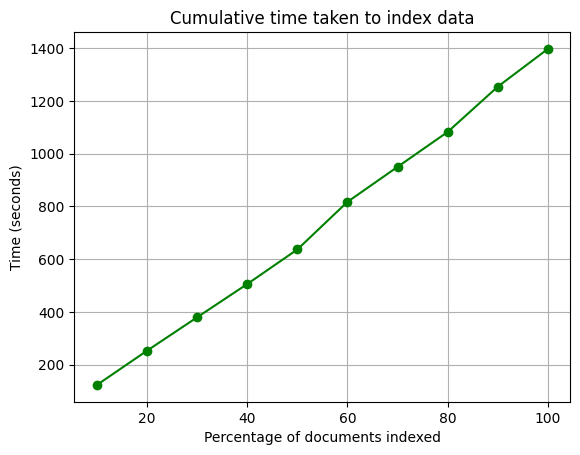

In [ ]:
# Calculating the cumulative sum of the times
cumulative_times = np.cumsum(times)
print(times)
print(cumulative_times)

# Plotting the cumulative times
plt.plot(range(10, len(cumulative_times) * 10 + 1, 10), cumulative_times, c='green', marker='o')
plt.xlabel('Percentage of documents indexed')
plt.ylabel('Time (seconds)')
plt.title('Cumulative time taken to index data')
plt.grid(True)
plt.show()

### Search
1. The `Searcher` object is the main high-level interface for reading the index.
2. The most important method on the `Searcher` object is `search()`, which takes a `whoosh.query.Query` object and returns a `Results` object.
3. The `Results` object acts like a list of the matched documents. You can use it to access the stored fields of each hit document, to display to the user.
4. The list of result documents is sorted by _score_. The default scoring algorithm used is BM25.

In [ ]:
# Defining the search function to perform the retrieval
def search(query_str, num_results):
    ix = open_dir("indexdir")
    with ix.searcher() as searcher:
        query = MultifieldParser(["title", "author", "venue", "year"], schema=ix.schema).parse(query_str)
        print("Search Query:\t\t"+query_str)
        print("No. of Docs to fetch:\t"+str(num_results))
        print("\nQuery:\t"+str(query)+"\n\n")
        results = searcher.search(query, limit=num_results)
        for i, hit in enumerate(results):
            print("-"*200)
            print(f"Rank: {i+1}\nScore: {hit.score}\nTitle: {hit['original_title']}\nAuthors: {hit['author']}\nVenue: {hit['venue']}\nYear: {hit['year']}")


### Seach (Using BM25 and TF-IDF Weighting Scores)

The code sets up a search index using the Whoosh library, defines a custom text analyzer with regex tokenization, lowercase filter and stopword filter, and provides two slightly different functions (`search_dblp`) to search the DBLP dataset for papers: one using TF-IDF weighting and the other using BM25 weighting, based on query string: "Deep Learning AND venue:AAAI AND year:2020".

In [ ]:
from whoosh import index, writing
from whoosh.fields import Schema, TEXT
from whoosh.analysis import RegexTokenizer, LowercaseFilter, StopFilter
nltk.download('stopwords')
stopword_set = set(stopwords.words('english'))

# Define custom analyzer
analyzer = RegexTokenizer() | LowercaseFilter() | StopFilter(stoplist=stopword_set)

# Define schema with the custom analyzer
schema = Schema(title=TEXT(stored=True, analyzer=analyzer),
                authors=TEXT(stored=True, analyzer=analyzer),
                venue=TEXT(stored=True, analyzer=analyzer),
                year=TEXT(stored=True))

# Create an index directory
if not os.path.exists("indexdir_new"):
    os.mkdir("indexdir_new")
    ix = index.create_in("indexdir_new", schema)
else:
    ix = index.open_dir("indexdir_new")

In [ ]:
from whoosh.qparser import MultifieldParser
from whoosh import scoring

def search_dblp(query_str, ix, limit=10):
    """Search DBLP dataset based on the given query string."""
    ix = open_dir("indexdir")
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
        # Use the title field for searching (can be adjusted to other fields as needed)
        query = MultifieldParser(["title", "venue", "authors", "year"], ix.schema).parse(query_str)
        results = searcher.search(query, limit=limit)

        # Print the number of matches
        print(f"Found {len(results)} matches.")

        # Display the results
        for i, hit in enumerate(results):
            print(f"Rank: {i+1}")
            print(f"Score: {hit.score}")
            print(f"Title: {hit['title']}")
            print(f"Author(s): {hit['authors']}")
            print(f"Venue: {hit['venue']}")
            print(f"Year: {hit['year']}")
            print('-'*40)  # separator

# Usage example:
search_query = "Deep Learning AND venue:AAAI AND year:2020"
search_dblp(search_query, ix)

Found 74 matches.
Rank: 1
Score: 37.70624206929641
Title: Knowledge Infused Learning (K-IL): Towards Deep Incorporation of Knowledge in Deep Learning.
Author(s): ['Ugur Kursuncu', 'Manas Gaur', 'Amit P. Sheth']
Venue: AAAI Spring Symposium: Combining Machine Learning with Knowledge Engineering (1)
Year: 2020
----------------------------------------
Rank: 2
Score: 28.842367580882843
Title: Using Pre-trained Transformer Deep Learning Models to Identify Named Entities and Syntactic Relations for Clinical Protocol Analysis.
Author(s): ['Miao Chen', 'Fang Du', 'Ganhui Lan', 'Victor S. Lobanov']
Venue: AAAI Spring Symposium: Combining Machine Learning with Knowledge Engineering (1)
Year: 2020
----------------------------------------
Rank: 3
Score: 24.991307488344642
Title: Mitigating Bias in Deep Nets with Knowledge Bases: the Case of Natural Language Understanding for Robots.
Author(s): ['Martino Mensio', 'Emanuele Bastianelli', 'Ilaria Tiddi', 'Giuseppe Rizzo 0002']
Venue: AAAI Spring Symp

In [ ]:
from whoosh.qparser import MultifieldParser
from whoosh import scoring

def search_dblp(query_str, ix, limit=10):
    """Search DBLP dataset based on the given query string."""
    ix = open_dir("indexdir")
    with ix.searcher() as searcher:
        # Use the title field for searching (can be adjusted to other fields as needed)
        query = MultifieldParser(["title", "venue", "authors", "year"], ix.schema).parse(query_str)
        results = searcher.search(query, limit=limit)

        # Print the number of matches
        print(f"Found {len(results)} matches.")

        # Display the results
        for i, hit in enumerate(results):
            print(f"Rank: {i+1}")
            print(f"Score: {hit.score}")
            print(f"Title: {hit['title']}")
            print(f"Author(s): {hit['authors']}")
            print(f"Venue: {hit['venue']}")
            print(f"Year: {hit['year']}")
            print('-'*40)  # separator

# Usage example:
search_query = "Deep Learning AND venue:AAAI AND year:2020"
search_dblp(search_query, ix)

Found 74 matches.
Rank: 1
Score: 22.594932902618922
Title: Do Not Have Enough Data? Deep Learning to the Rescue!
Author(s): ['Ateret Anaby-Tavor', 'Boaz Carmeli', 'Esther Goldbraich', 'Amir Kantor', 'George Kour', 'Segev Shlomov', 'Naama Tepper', 'Naama Zwerdling']
Venue: AAAI
Year: 2020
----------------------------------------
Rank: 2
Score: 22.594932902618922
Title: Symmetrical Synthesis for Deep Metric Learning.
Author(s): ['Geonmo Gu', 'ByungSoo Ko']
Venue: AAAI
Year: 2020
----------------------------------------
Rank: 3
Score: 22.42454132386872
Title: Knowledge Infused Learning (K-IL): Towards Deep Incorporation of Knowledge in Deep Learning.
Author(s): ['Ugur Kursuncu', 'Manas Gaur', 'Amit P. Sheth']
Venue: AAAI Spring Symposium: Combining Machine Learning with Knowledge Engineering (1)
Year: 2020
----------------------------------------
Rank: 4
Score: 22.001231953897964
Title: Deep Reinforcement Learning for General Game Playing.
Author(s): ['Adrian Goldwaser', 'Michael Thielsch

# 3.3 DEVELOPING RESEARCH TREND EXPLORER

####  The code loads a dataset of publications as JSON files, filters for papers in the SIGIR conference(can also be changed accordingly), and identifies top key phrases in the titles of these papers for each year. It then visualizes the trends of these key phrases over the past 15 years.



1. **Data Loading**: Reads JSON files (named `dblp_0.json` to `dblp_111.json`) containing publication data into one combined list.
2. **Filtering**: Selects papers from the 'SIGIR' conference.
3. **Title Aggregation**: Groups titles of SIGIR papers by their publication year.
4. **Key Phrases Extraction**: For each year, it identifies the top 2 key phrases from titles using TF-IDF, ignoring common words.
5. **Visualization**: Plots the trends of these key phrases importance over the past 15 years for the SIGIR conference.

In [ ]:
import json
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load the JSON data
data = []
for i in range(111):
    try:
        with open(f'dataset/dblp_{i}.json', 'r') as f:
            data.extend(json.load(f))
    except FileNotFoundError:
        break


In [ ]:
# Filter for SIGIR conference
sigir_papers = [paper for paper in data if paper['venue'] == 'SIGIR']

# Combine titles for each year
yearly_texts = {}
for paper in sigir_papers:
    year = paper['year']
    title = paper['title'] if paper['title'] is not None else ''  # Handle None titles
    if year not in yearly_texts:
        yearly_texts[year] = ""
    yearly_texts[year] += title + " "

# Find key phrases using TF-IDF and their frequencies
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=2, stop_words='english')
key_phrases_freq = {}
for year, texts in yearly_texts.items():
    X = vectorizer.fit_transform([texts])
    features = vectorizer.get_feature_names_out()
    frequencies = X.toarray()[0]
    key_phrases_freq[year] = dict(zip(features, frequencies))

# Plotting for all the years
years = sorted(key_phrases_freq.keys())
for year in years:
    for phrase, freq in key_phrases_freq[year].items():
        plt.plot(year, freq, marker='o', label=f"{year}-{phrase}")

plt.title('Trends of Top Key Phrases in SIGIR Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency(%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=2)
plt.tight_layout()
plt.grid(True, which='both')
plt.show()


### Plot Analysis &  Visualization

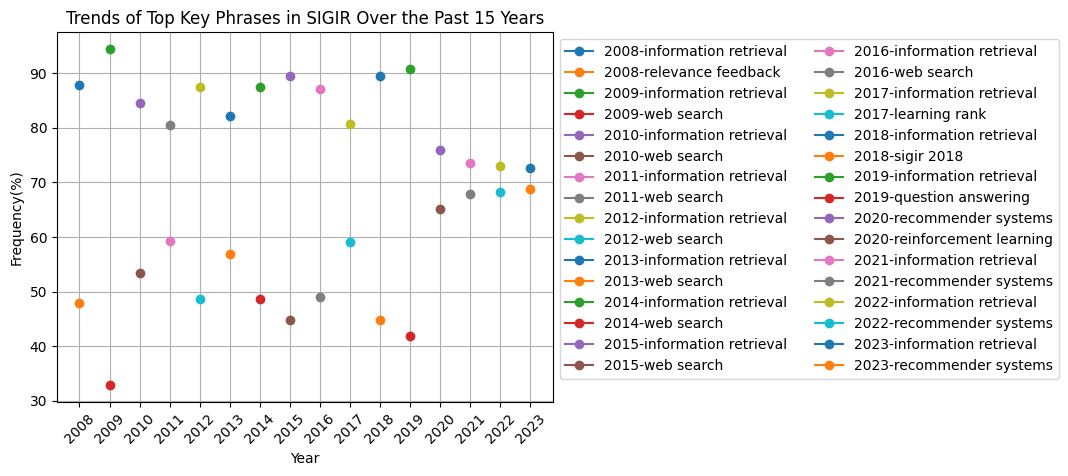

In [ ]:
#Plotting for the past 15 years

# Determine the range for the last 15 years
latest_year = max(map(int, yearly_texts.keys()))
start_year = latest_year - 15

# Filter for the last 15 years
filtered_yearly_texts = {year: texts for year, texts in yearly_texts.items() if int(year) >= start_year}

# Find key phrases using TF-IDF and their frequencies for the last 15 years
key_phrases_freq = {}
for year, texts in filtered_yearly_texts.items():
    X = vectorizer.fit_transform([texts])
    features = vectorizer.get_feature_names_out()
    frequencies = X.toarray()[0]
    key_phrases_freq[year] = dict(zip(features, frequencies))

# Plotting
years = sorted(key_phrases_freq.keys())
for year in years:
    for phrase, freq in key_phrases_freq[year].items():
        plt.plot(year, freq*100, marker='o', label=f"{year}-{phrase}")

plt.title('Trends of Top Key Phrases in SIGIR Over the Past 15 Years')
plt.xlabel('Year')
plt.ylabel('Frequency(%)')

plt.xticks(years, rotation=45)  # Set x-axis labels as the years
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)
#plt.tight_layout()
plt.grid(True, which='both')
plt.show()

- This function `plot_trend_for_phrase(phrase)` visualizes the yearly occurrence trend of a specified phrase (e.g., "neural network") within SIGIR paper

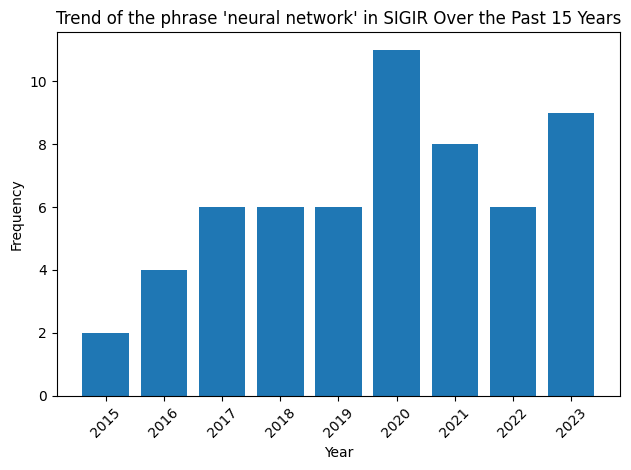

In [ ]:
import numpy as np


def plot_trend_for_phrase(phrase):
    # Extract frequency of the given phrase for each year
    phrase_frequencies = {}
    for year, texts in filtered_yearly_texts.items():
        count = texts.lower().count(phrase.lower())
        if count > 0:  # only include years where the phrase appeared at least once
            phrase_frequencies[year] = count

    if not phrase_frequencies:
        print(f"No occurrences found for the phrase '{phrase}' in the last 15 years.")
        return

    # Bar chart plotting
    years = sorted(phrase_frequencies.keys())
    frequencies = [phrase_frequencies[year] for year in years]

    plt.bar(years, frequencies, align='center')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title(f"Trend of the phrase '{phrase}' in SIGIR Over the Past 15 Years")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Test with a given phrase
plot_trend_for_phrase("neural network")


- This function `plot_trend_for_phrase_in_conferences(phrase, conferences)` visualizes the yearly occurrence trends of a specified key phrase (e.g., "neural network") within the specified paper titles from a list of given conferences over the past 15 years.

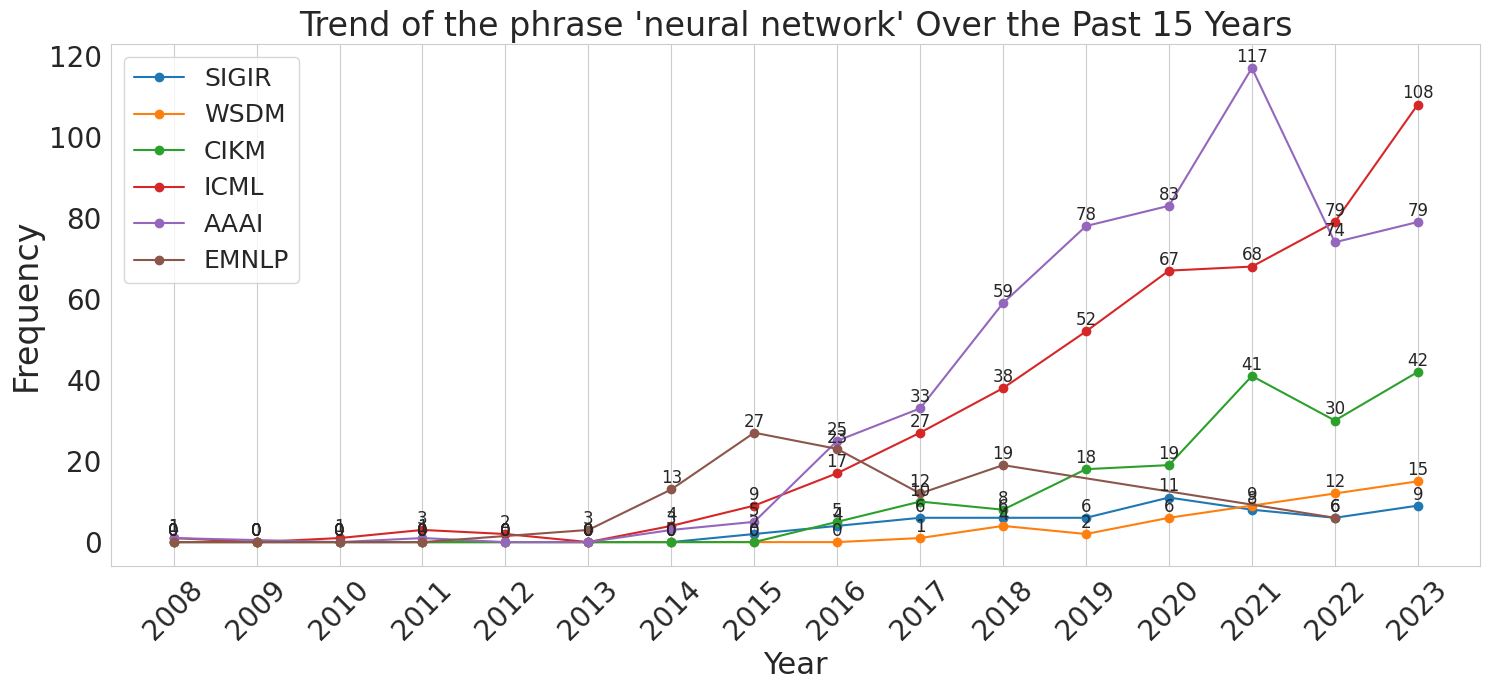

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_trend_for_phrase_in_conferences(phrase, conferences):
    # Initial placeholder for data
    conference_frequencies = {conference: {} for conference in conferences}

    # Extract frequency of the given phrase for each year for each conference
    for paper in data:
        year = paper['year']
        venue = paper['venue']
        title = paper['title'] if paper['title'] is not None else ''
        count = title.lower().count(phrase.lower())

        if venue in conferences and int(year) >= start_year:
            if year not in conference_frequencies[venue]:
                conference_frequencies[venue][year] = 0
            conference_frequencies[venue][year] += count

    # Plotting
    plt.figure(figsize=(15, 7))

    for conference, yearly_data in conference_frequencies.items():
        years = sorted(yearly_data.keys())
        frequencies = [yearly_data[year] for year in years]
        if frequencies:  # check if there's data to plot
            plt.plot(years, frequencies, marker='o', label=conference)
            # Annotating the count on each data point
            for i, txt in enumerate(frequencies):
                plt.text(years[i], frequencies[i] + 1.5, str(txt), fontsize=12, ha='center')

    plt.xlabel('Year',fontsize=22)
    plt.ylabel('Frequency',fontsize=24)
    plt.title(f"Trend of the phrase '{phrase}' Over the Past 15 Years", fontsize=24)
    plt.legend(fontsize=18)  # Increase font size
    plt.xticks(rotation=45, fontsize=20)  # Increase font size
    plt.yticks(fontsize=20)  # Increase font size
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# List of conferences to consider
conferences = ["SIGIR", "WSDM", "CIKM", "SIGMOD", "VLDB", "ICML", "AAAI", "ACL", "EMNLP"]

# Test with a given phrase
plot_trend_for_phrase_in_conferences("neural network", conferences)


In [ ]:
import numpy as np
import plotly.express as px
def plot_trend_for_phrase_in_conferences(phrase, conferences, data):

    conference_frequencies = {conference: {} for conference in conferences}

    # Extract frequency of the given phrase for each year for each conference
    for paper in data:
        year = paper['year']
        venue = paper['venue']
        title = paper['title'] if paper['title'] is not None else ''
        count = title.lower().count(phrase.lower())

        if venue in conferences and int(year) >= start_year:
            if year not in conference_frequencies[venue]:
                conference_frequencies[venue][year] = 0
            conference_frequencies[venue][year] += count

    # Create data for Plotly
    data = []
    for conference, yearly_data in conference_frequencies.items():
        years = sorted(yearly_data.keys())
        frequencies = [yearly_data[year] for year in years]
        if frequencies:  # check if there's data to plot
            for i, year in enumerate(years):
                data.append({'Conference': conference, 'Year': year, 'Frequency': frequencies[i]})
    # Create a bubble chart using Plotly
    fig = px.scatter(data, x='Year', y='Frequency', size='Frequency', color='Conference', hover_name='Conference',
                     labels={'Year': 'Year', 'Frequency': 'Frequency'},
                     title=f"Trend of the phrase '{phrase}' Over the Past 15 Years",
                     size_max=60)

    # Customize the appearance of the chart
    fig.update_layout(xaxis=dict(tickmode='linear', tick0=start_year, dtick=1, tickfont=dict(size=24),tickangle=45),
                      xaxis_title_font=dict(size=24),
                      yaxis=dict(tickfont=dict(size=24)),
                      yaxis_title_font=dict(size=24),
                      title_font=dict(size=26),

                      legend=dict(font=dict(size=20), x=0.03, y=1)
                       )
    fig.update_traces(marker=dict(opacity=0.5, line=dict(width=2)))
    fig.show()

# List of conferences to consider
conferences = ["SIGIR", "WSDM", "CIKM", "SIGMOD", "VLDB", "ICML", "AAAI", "ACL", "EMNLP"]
plot_trend_for_phrase_in_conferences("neural network", conferences, data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


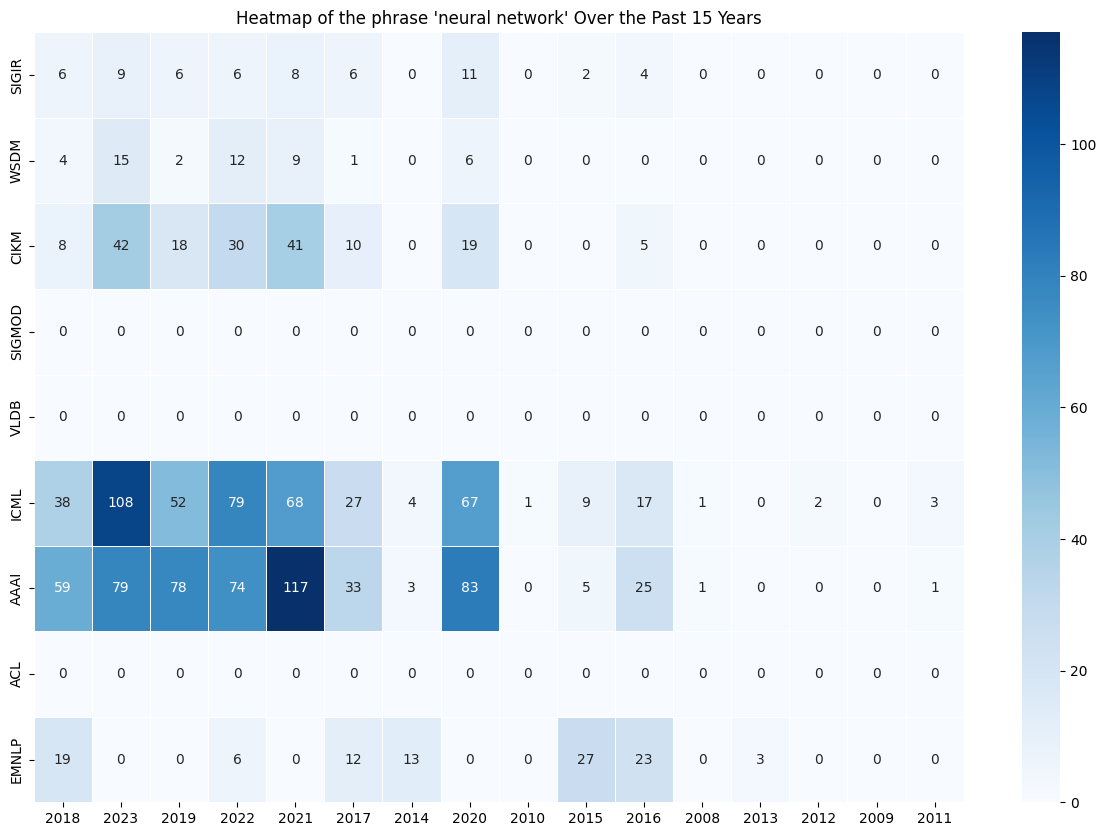

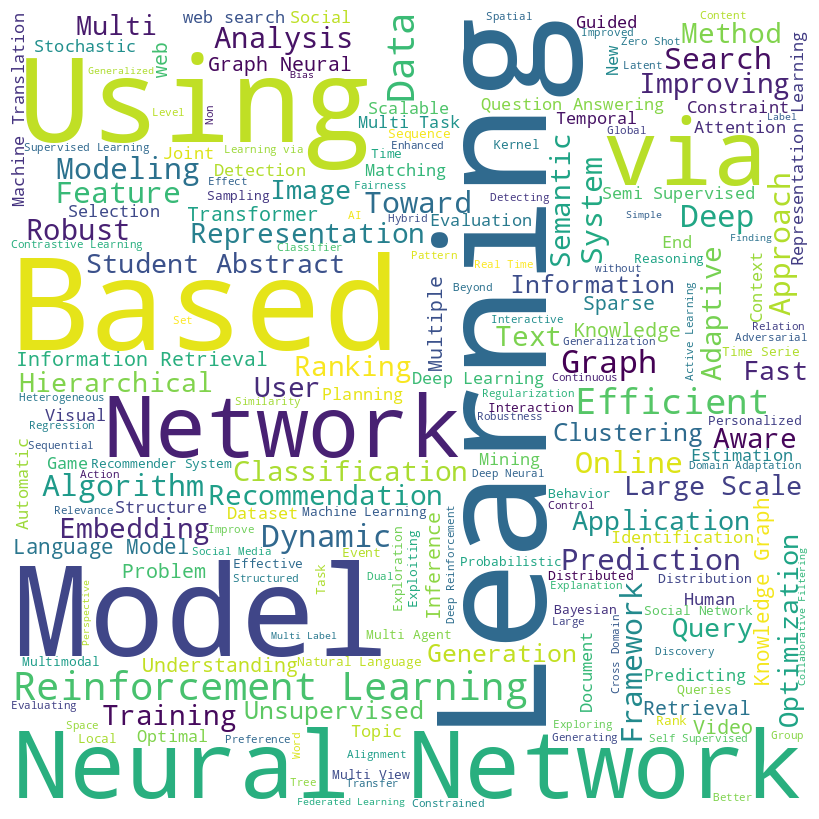

In [ ]:
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

def plot_heatmap(phrase, conferences):

    conference_frequencies = {conference: {} for conference in conferences}

    for paper in data:
        year = paper['year']
        venue = paper['venue']
        title = paper['title'] if paper['title'] is not None else ''
        count = title.lower().count(phrase.lower())

        if venue in conferences and int(year) >= start_year:
            if year not in conference_frequencies[venue]:
                conference_frequencies[venue][year] = 0
            conference_frequencies[venue][year] += count

    df = pd.DataFrame(conference_frequencies).T
    df = df.fillna(0)

    # Plotting heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(df, annot=True, cmap='Blues', fmt=".0f", linewidths=.5)
    plt.title(f"Heatmap of the phrase '{phrase}' Over the Past 15 Years")
    plt.show()

def generate_wordcloud(conferences):
    # Extracting all titles for the specified conferences over the past 15 years
    titles = ' '.join([paper['title'] for paper in data if paper['venue'] in conferences and int(paper['year']) >= start_year and paper['title'] is not None])

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stopwords.words('english')),
                min_font_size = 10).generate(titles)

    # Plotting the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

nltk.download('stopwords')

# List of conferences to consider
conferences = ["SIGIR", "WSDM", "CIKM", "SIGMOD", "VLDB", "ICML", "AAAI", "ACL", "EMNLP"]
start_year = 2008
# Generate heatmap
plot_heatmap("neural network", conferences)
# Generate word cloud
generate_wordcloud(conferences)


## Application

In [ ]:
search_query = input('Search for...\n')
N = int(input("How many Publications do you want to be returned?\nN = "))
search(search_query, N)

Search Query:		neural network AND year:2020 AND venue:SIGIR
No. of Docs to fetch:	7

Query:	((title:neural OR author:neural OR venue:neural OR year:neural) AND (title:network OR author:network OR venue:network OR year:network) AND year:2020 AND venue:sigir)


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Rank: 1
Score: 19.238259918477148
Title: MGNN: A Multimodal Graph Neural Network for Predicting the Survival of Cancer Patients.
Authors: Jianliang Gao, Tengfei Lyu, Fan Xiong, Jianxin Wang 0001, Weimao Ke, Zhao Li 0007
Venue: SIGIR
Year: 2020
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Rank: 2
Score: 19.238259918477148
Title: Alleviating the Inconsistency Problem of Applying Gra